# Code content
Denoising autoencoder and prediction encoder with shared weights. 
Method: model with two outputs and a loss function per output.

In [1]:
# additional imports of python modules
# python module imports needed in customized functions:
import numpy as np
import tensorflow as tf
import sys

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as imgplot
import time
import pandas as pd
#tf.set_random_seed(1)
#np.random.seed(1)
import sys
tf.__version__, sys.version_info



('1.4.0',
 sys.version_info(major=3, minor=6, micro=3, releaselevel='final', serial=0))

In [2]:
import keras
#from keras.datasets import mnist
#from keras.models import Sequential
#from keras.layers import Dense, Dropout, Activation, Flatten, Input
#from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
#from keras.layers.normalization import BatchNormalization

Using TensorFlow backend.


# Data read-in
Load small external MNIST data set when for working local on windows

# Import data from keras

In [3]:
from keras.datasets import mnist
#import numpy as np
(x_train, y_train), (x_test, y_test) = mnist.load_data()

We will normalize all values between 0 and 1 and we will flatten the 28x28 images into vectors of size 784.

In [4]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

(60000, 784)
(10000, 784)


## corrupt images with noise

In [5]:
noise_factor = 0.0 # set to zero to go back to clean images
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

In [6]:
'''
def my_noise(input_layer, sd, scope):
    with tf.variable_scope(scope) as v_scope:
        noise = tf.random_normal(shape=tf.shape(input_layer), mean=0.0, stddev=sd, dtype=tf.float32) 
        return input_layer + noise
'''

'\ndef my_noise(input_layer, sd, scope):\n    with tf.variable_scope(scope) as v_scope:\n        noise = tf.random_normal(shape=tf.shape(input_layer), mean=0.0, stddev=sd, dtype=tf.float32) \n        return input_layer + noise\n'

# Autoencoder example
from https://blog.keras.io/building-autoencoders-in-keras.html

In [7]:
from keras.layers import Input, Dense, GaussianNoise, BatchNormalization, Activation
from keras.models import Model

# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats
stddev = 0.05

In [8]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

In [9]:
def build_encoder_layer(encoding_dim_,layer_id,stddev_=0.05):
    """
    Create the layers
    
    Parameters
    ==========
    
    encoding_dim_:int
        number of perceptons 
    layer_id: string
        part of the name
    stddev: double
        standard deviation of the Gaussion noise layer
        
    Returns
    =======
    
    x,y: I don't know what this is
    
    """
    sublayers={}
    s_id = 'encoder_' + layer_id + '/'
    sublayers['lin_trans']=Dense(encoding_dim_,activation = None,name=s_id + 'lt')
    sublayers['noise_add']=GaussianNoise(stddev_,name=s_id + 'noise')
    sublayers['batch_norm']=BatchNormalization(name=s_id + 'bn')
    sublayers['activation']=Activation('relu',name=s_id + 'output')
    return sublayers

In [10]:
def link_sublayer_ae(x,sublayers):
    """
    Link the sublayers for the autoencoder
    
    Parameters
    ==========
    x: input for the first sublayer
    
    sublayers: dict containing the sublayers
    
    """
    try:
        x=sublayers['lin_trans'](x)
        y=sublayers['noise_add'](x)
        x=sublayers['batch_norm'](y)
        x=sublayers['activation'](x)
    except:
        print("Something failed")
    return x,y

def link_sublayer_supervised(x,sublayers):
    """
    Link the sublayers for the supervised approach
    
    Parameters
    ==========
    x: input for the first sublayer
    
    sublayers: dict containing the sublayers
    
    """
    try:
        y=sublayers['lin_trans'](x)
        x=sublayers['batch_norm'](y)
        x=sublayers['activation'](x)
    except:
        print("Something failed")
    return x,y

def decoding_layer(input_layer,layer_id,decoding_dim_,activation_name):
    decoded_ = Dense(decoding_dim_,activation = activation_name,name = 'decoder_' + layer_id + '/output')(input_layer)
    return decoded_

In [11]:
encoding_dim = 128

## Create the clean and corrupted encoders
##########################################
# Input layer
input_img = Input(shape=(784,),name = 'input_img')
# Build encoder sublayers
encoder_layers={}
encoder_layers['1']=build_encoder_layer(encoding_dim,'1')
# NOTE:  Building the encoder layers only once but linking them twice ensures that the same weights are used by the AE and the clean encoder
# Corrupt input and link them
corrupted_img          = GaussianNoise(stddev,name="corrupt_input")(input_img)
encoded,sidepath_ae    = link_sublayer_ae(corrupted_img,encoder_layers['1'])
# Link the clean encoder 
sv_encoded,sidepath_sv = link_sublayer_supervised(input_img,encoder_layers['1'])
# channel the clean encoder output into the classifier
predicted_labels = Dense(10,activation='sigmoid',name='predictor')(sv_encoded)

## Create the decoder
##########################################
# Build a decoder
decoder_layers={}
decoder_layers['1']=Dense(784, activation='sigmoid',name='decoded_image')
# link the decoder to the corrupted encoder
decoded=decoder_layers['1'](encoded)




# model A: one input with two outputs
Train a model with a denoising AE and a clean encoder with shared weights. In the compiler we define two loss functions. This construction ensures that each loss function acts  on one output. NOTE: the loss function does not use the model inputs, but only the outputs and the  target outputs (y_pred and y_true). The true output of an AE are the original images and the true outputs for the supervised loss are the true labels. These are given when fitting, using the losses defined in the compilation. 


In [12]:
ladder = Model([input_img],[decoded,predicted_labels])
ladder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          (None, 784)          0                                            
__________________________________________________________________________________________________
corrupt_input (GaussianNoise)   (None, 784)          0           input_img[0][0]                  
__________________________________________________________________________________________________
encoder_1/lt (Dense)            (None, 128)          100480      corrupt_input[0][0]              
                                                                 input_img[0][0]                  
__________________________________________________________________________________________________
encoder_1/noise (GaussianNoise) (None, 128)          0           encoder_1/lt[0][0]               
__________

## plot model A
the clean and the corrupted encoders share the same weights. The corrupted channel is then decoded and the clean one is used for supervised classification.

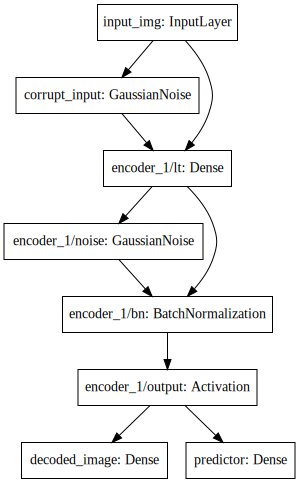

In [13]:
SVG(model_to_dot(ladder).create(prog='dot',format='svg'))

## Compile and fit model A

the compiler defines two loss functions: a binary loss for the unsupervised decoding of the corrupted images. A categorical cross-entropy for the supervised classification using the clean encoder. 

In [16]:
ladder.compile(optimizer='adadelta', loss=['binary_crossentropy','categorical_crossentropy'],loss_weights=[1.0,1.0])

In [17]:
info=ladder.fit(x_train,[x_train,y_train],
                epochs=10,
                batch_size=100,
                shuffle=True,
                validation_data=(x_test,[x_test,y_test]))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 26s 440us/step - loss: 0.4325 - decoded_image_loss: 0.1080 - predictor_loss: 0.3245 - val_loss: 0.2796 - val_decoded_image_loss: 0.1054 - val_predictor_loss: 0.1742
Epoch 2/10
60000/60000 [==============================] - 14s 227us/step - loss: 0.2607 - decoded_image_loss: 0.1080 - predictor_loss: 0.1527 - val_loss: 0.2402 - val_decoded_image_loss: 0.1031 - val_predictor_loss: 0.1370
Epoch 3/10
60000/60000 [==============================] - 9s 142us/step - loss: 0.2200 - decoded_image_loss: 0.1060 - predictor_loss: 0.1139 - val_loss: 0.2299 - val_decoded_image_loss: 0.1008 - val_predictor_loss: 0.1291
Epoch 4/10
60000/60000 [==============================] - 8s 141us/step - loss: 0.1964 - decoded_image_loss: 0.1040 - predictor_loss: 0.0924 - val_loss: 0.2094 - val_decoded_image_loss: 0.0996 - val_predictor_loss: 0.1098
Epoch 5/10
60000/60000 [==============================] - 8s

# Predicting and plotting

## encode and decode some digits
note that we take them from the *test* set


###  use ladder to predict
the ladder has two outputs
1. decoded images of the denoising autoencoder ==> display them as digit images
2. predicted digits of the clean encoder ==> take the max of the softmax to predict a digit

In [ ]:
[decoded_imgs,encoder_output] = ladder.predict(x_test)
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    
plt.show()
for i in range(n):
    print('predicted digit:',np.argmax(encoder_output[i]))